In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from skorch import NeuralNetRegressor

%matplotlib inline

# Convolutional Neural Network for Time Series

## Univariate CNN 

Univarate time series are datasets contains only one sinle series of observations with a temporal ordering. Model need to learn from past observations to predict next value in sequence.

### Dataset

Monthly sunspot dataset describes a monthly count of number of observed sunspots for just over 230 years from 1749 to 1983. Dataset contains 2820 observations. 

You can download data from: https://datamarket.com/data/set/22ti/zuerich-monthly-sunspot-numbers-1749-1983#!ds=22ti&display=line

In [5]:
uni_df = pd.read_csv('datasets/zuerich-monthly-sunspot-numbers-.csv', 
                     sep=';', names=['month', 'observations'], header=0)
uni_df.dropna(inplace=True)
uni_df['month'] = pd.to_datetime(uni_df['month'])
uni_df.set_index('month', inplace=True)
uni_df.head(5)

,observations
month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [6]:
uni_df.shape

(2820, 1)

In [7]:
uni_df.dtypes

observations    float64
dtype: object

The time series is univariate, it can be easly plotted.

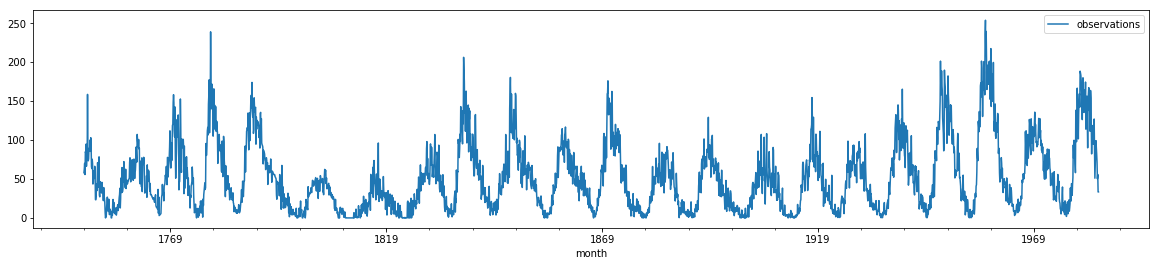

In [8]:
uni_df.plot(figsize=(20, 4))

### Data preparation

PyTorch provides tool for preparing data. It makes code more readable and reusable. 

In [17]:
def make_sequence(series, window):
    X, y = list(), list()
    size = len(series)
    for i in range(size):
        end_ix = i + window
        if end_ix > size - 1:
            break
        seq_x, seq_y = series[i:end_ix], series[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    return (np.array(X, dtype=np.float32).reshape((-1, D_in, 1)), np.array(y, dtype=np.float32).reshape(-1))

def prepare_dataset(series, window):
    X, y = make_sequence(series, 10)
    return torch.from_numpy(X), torch.from_numpy(y)

In [124]:
threshold_month = '1939-11-01'
window = 10
D_in = window

X_train, y_train = prepare_dataset(uni_df[uni_df.index <= threshold_month].values, 10)
X_test, y_test = prepare_dataset(uni_df[uni_df.index > threshold_month].values, 10)

Data set needs to be splitted to train and test sets. Torch has good tool from sampling 

In [125]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

### One-Dimensional Convolutional Neural Network Model (1D CNN)

1D CNN is a model that has convolutional hidden layer that calculates over one dimensional sequence. 

Select device.

In [126]:
device = 'cuda:0'

In [235]:
class OneDCNN(nn.Module):
    def __init__(self, D_in):
        super(OneDCNN, self).__init__()
        self.conv1 = nn.Conv1d(D_in, 16, 1, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64, 50)
        self.fc2 = nn.Linear(50, 4)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = x.view(-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
one_dcnn = OneDCNN(D_in)
one_dcnn

OneDCNN(
  (conv1): Conv1d(10, 16, kernel_size=(1,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=4, bias=True)
)

Define a loss function and optimizer.

In [236]:
criterion = nn.MSELoss()
optimizer = optim.Adam(one_dcnn.parameters(), lr=0.0001)

Prepare train and test dataloader.

In [237]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, drop_last=True, num_workers=8, sampler=SequentialSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, drop_last=True, num_workers=8, sampler=SequentialSampler(test_dataset))

Train network

In [238]:
one_dcnn.train()
n_epoch = 20
loss_history = list()
for epoch in range(n_epoch):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = one_dcnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / i))
    loss_history.append(running_loss )

[1] loss: 2407.389
[2] loss: 385.485
[3] loss: 288.089
[4] loss: 225.997
[5] loss: 187.390
[6] loss: 167.720
[7] loss: 155.303
[8] loss: 146.114
[9] loss: 138.103
[10] loss: 130.738
[11] loss: 123.800
[12] loss: 117.224
[13] loss: 110.775
[14] loss: 103.731
[15] loss: 95.124
[16] loss: 88.110
[17] loss: 82.402
[18] loss: 77.316
[19] loss: 72.789
[20] loss: 68.703


The plot below shows loss error.

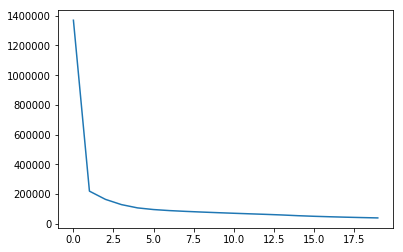

In [239]:
plt.plot(loss_history);

Validate the network

Predict new observations

In [241]:
one_dcnn.eval()
test_loss = 0
correct = 0
predictions = list()
features = list()
labels = list()
with torch.no_grad():
    for data, target in test_loader:
        features.append(data)
        predictions.append(one_dcnn(data))
        labels.append(target)
        
predictions = np.array(list(map(lambda x: x.numpy(), predictions))).flatten()
labels = np.array(list(map(lambda x: x.numpy(), labels))).flatten()
features  = np.array(list(map(lambda x: x.numpy(), features))).reshape(-1, 10)

The plot shows observations and predictions for testing period.

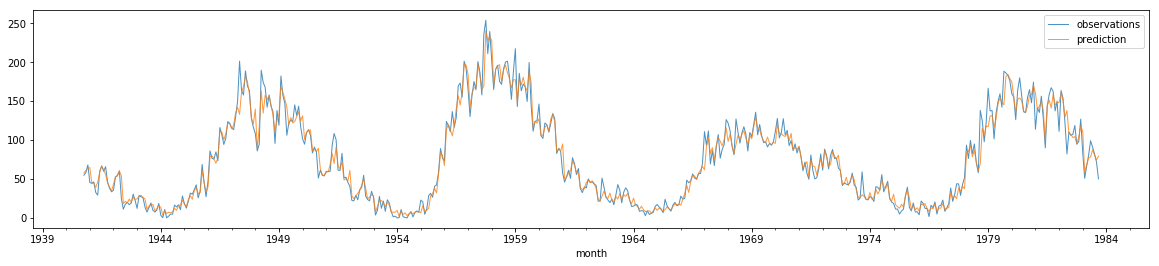

In [244]:
test_df = uni_df[uni_df.index > threshold_month].loc['1940-10-01':'1983-09-01', :]
test_df['prediction'] = predictions
test_df['prediction'] = test_df['prediction']
test_df.plot(figsize=(20, 4), lw=1, alpha=0.8)

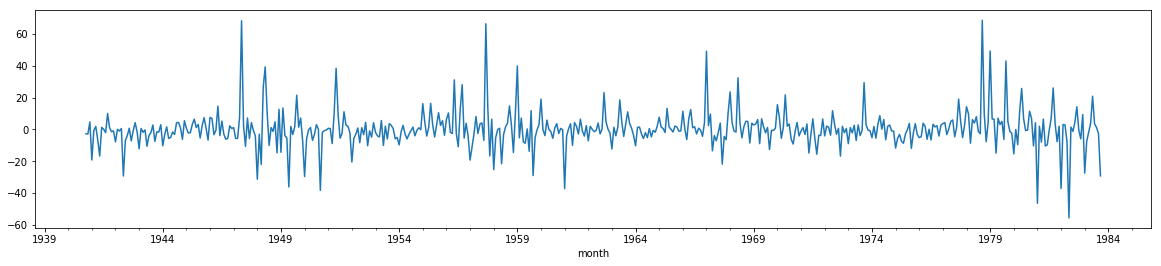

In [245]:
test_df['error'] = test_df['observations'] - test_df['prediction']
test_df.error.plot(figsize=(20, 4))